In [1]:
import torch
from egnn_pytorch import EGNN_Network

import torch.nn as nn
import numpy as np
import random
import torch.nn.functional as F

#feats = torch.ones((1,24), dtype=int)
# Define learnable embeddings


coors = torch.tensor([[
    [42.677, 7.757, 12.295],   # N
    [42.591, 6.743, 12.364],   # H
    [43.902, 8.261, 12.895],   # CA
    [43.609, 9.188, 13.389],   # HA
    [44.899, 8.748, 11.824],   # C
    [45.598, 9.722, 12.046],   # O
    [44.507, 7.304, 13.893],   # CB
    [44.553, 6.216, 13.844],   # HB2
    [43.949, 7.467, 14.815],   # HB3
    [45.942, 7.714, 14.190],   # CG
    [46.624, 7.000, 14.652],   # HG2
    [46.297, 7.552, 13.172],   # HG3
    [46.098, 8.566, 15.453],   # CD
    [45.432, 9.428, 15.421],   # HD2
    [45.864, 8.023, 16.369],   # HD3
    [47.437, 9.171, 15.645],   # NE
    [48.036, 8.718, 16.335],   # HE
    [48.159, 9.908, 14.753],   # CZ
    [47.793, 10.201, 13.491],  # NH1
    [48.497, 10.668, 12.920],  # HH11
    [46.880, 10.644, 13.590],  # HH12
    [49.340, 10.374, 15.149],  # NH2
    [50.143, 9.902, 14.733],   # HH21
    [49.831, 10.816, 15.926],  # HH22
]], dtype=torch.float32)





import itertools

species = torch.tensor([
    0,  # N
    1,  # H
    2,  # CA
    1,  # HA
    2,  # C
    3,  # O
    2,  # CB
    1,  # HB2
    1,  # HB3
    2,  # CG
    1,  # HG2
    1,  # HG3
    2,  # CD
    1,  # HD2
    1,  # HD3
    0,  # NE
    1,  # HE
    2,  # CZ
    0,  # NH1
    1,  # HH11
    1,  # HH12
    0,  # NH2
    1,  # HH21
    1   # HH22
], dtype=torch.int)


# Create a tensor with 1s for hydrogen (species == 1) and 0s elsewhere
feats = torch.where(species == 1, torch.tensor(1), torch.tensor(0)).unsqueeze(0)


# Indices to keep
an = [15, 18,21] #nnn
cat = [16,17,19,20,22,23]

# Create a zero tensor
new_species = torch.zeros_like(species)

# Set specified indices to 1
new_species[an] = -1
new_species[cat] = 1




def contrastive_loss(latent_features, species, margin):
    loss = 0.0

    positive_pairs = [(i, j) for i, j in itertools.combinations(range(len(species)), 2) if species[i] == species[j]]
    negative_pairs = [(i, j) for i, j in itertools.combinations(range(3), 2) if species[i] != species[j]]


    # Positive pairs
    for i, j in positive_pairs:
        z_i, z_j = latent_features[i], latent_features[j]
        dist = torch.norm(z_i - z_j, p=2)  # Euclidean distance
        loss += dist ** 2  # Minimize distance for positive pairs

    # Negative pairs
    for i, j in negative_pairs:
        z_i, z_j = latent_features[i], latent_features[j]
        dist = torch.norm(z_i - z_j, p=2)
        loss += torch.clamp(margin - dist, min=0) ** 2  # Enforce margin



    return loss / (len(positive_pairs) + len(negative_pairs))


#low depth = local, high depth = l.r.
net = EGNN_Network(
    num_tokens = 10, #vocabulary siye, number of unique species
    num_positions = 24,  #number of nodes         # unless what you are passing in is an unordered set, set this to the maximum sequence length
    dim = 2,# #internal rep size. c has square dependence. richer rep but overfitting for small d.s.
    depth = 2, #number of layers #deeper need more memort to store intermediate reps
    num_nearest_neighbors = 3, #number of nearest neighbors to consider #make this the max hood size
    coor_weights_clamp_value = 2.   # absolute clamped value for the coordinate weights, needed if you increase the num neareest neighbors
)




optimizer = torch.optim.Adam(net.parameters(), lr=0.01, weight_decay=1e-3)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.01)
#scheduler = LambdaLR(optimizer, lr_lambda=warmup_lr)
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
# Training loop
for epoch in range(300):
    optimizer.zero_grad()
    print(coors.unsqueeze(0).shape)
    # Forward pass
    #feats_out, coors_out = net(feats, coors.unsqueeze(0))
    print(2)
    

    # Compute loss
    latent_features = feats_out[0]

    #latent_features = F.normalize(latent_features, p=2, dim=1)

    
    #loss = contrastive_loss(latent_features, species, margin=3)

    # Backward pass
    #loss.backward()
    #optimizer.step()

    
    
    #print(f"Epoch {epoch}: Loss = {loss.item()}")
    #print(coors_out, feats_out)
    


    ####
    

    featsss_, coors_out = net(species.unsqueeze(0), coors)
# Apply softmax along a specific dimension (e.g., last dimension)
    featss_ = F.softmax(nn.Tanh()(nn.LeakyReLU(negative_slope=0.01)(featsss_)), dim=1)
    #featss_ = F.softmax((nn.LeakyReLU(negative_slope=3)(featsss_)), dim=1)  # Sum along dim=1 will be 1    #featss_ = nn.Tanh()(nn.ReLU()(featsss_))
    #feats_ = F.normalize(latent_features, p=1, dim=1)  # Normalize for cosine similarity

    
# Shift and normalize
    #shifted_features = nn.Tanh()(featss_) + 1  # Shift to [0, 2]
    #normalized_features = shifted_features / shifted_features.sum()  # Normalize to sum to 1

# Shift back to [-1, 1] range while preserving sum-to-1
    #final_features = 2 * normalized_features - 1

    feats_ = featss_  / featss_.max() 
    #feats_ = featss_  / featss_.abs().max()
    

    

    # Compute loss
    latent_feature = feats_[0]

    #latent_features = F.normalize(latent_features, p=2, dim=1)

    
    L = contrastive_loss(latent_feature, new_species, margin=3)

        # Backward pass
    L.backward()
    optimizer.step()

    #scheduler.step()

    #for name, param in net.named_parameters():
    #    if 'coors_mlp' in name or param.grad.norm() < 1e-7:
    #        torch.nn.init.xavier_uniform_(param)

    print(f"Epoch {epoch}: Loss = {L.item()}")








/home/jrhoernschemeyer/.local/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


torch.Size([1, 1, 24, 3])
2


NameError: name 'feats_out' is not defined

In [409]:
out = torch.mean(latent_feature, dim=1)
out.sum()/24

tensor(0.0536, grad_fn=<DivBackward0>)

In [410]:
f = out.detach().numpy()*coors[0].detach().numpy().T
combined = np.column_stack(f).flatten()
combined.reshape(-1, 3)
def divergence(field):
    "return the divergence of a n-D field"
    return np.gradient(field)
d=divergence(combined)

D=d.reshape(-1,3)

In [411]:
np.sum(D[0])
[np.sum(d) for d in D]

[-1.6302304,
 -0.27203915,
 0.15107414,
 0.4328919,
 -0.2994846,
 -0.28939247,
 0.20640448,
 -0.06586999,
 -0.11000931,
 -0.15850577,
 0.30847052,
 0.13495052,
 -0.24725938,
 -0.06670755,
 1.145556,
 -0.7427796,
 -0.1993866,
 1.1014365,
 -0.7487712,
 -0.54972464,
 0.6024828,
 12.464174,
 -9.112336,
 -4.115159]

In [403]:
sum([9.12401,
 -5.8246174,
 -6.7942276])

-3.494835

In [385]:
np.sum([1.5521183,-0.61356544,-13.533088])

-12.59453514

In [508]:
2#4\cdot\operatorname{csch}\left(2\left(.55x+.5\right)\right)-9
#24*np.csc(2*(.55*12.59 + .5)) - 9

x=0
(24*1/(1+x)) - 


4.0

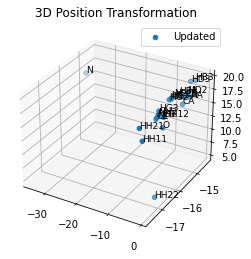

In [37]:
from matplotlib import pyplot as plt

species_strings = [
    "N",    # 0
    "H",    # 1
    "CA",   # 2
    "HA",   # 1
    "C",    # 2
    "O",    # 3
    "CB",   # 2
    "HB2",  # 1
    "HB3",  # 1
    "CG",   # 2
    "HG2",  # 1
    "HG3",  # 1
    "CD",   # 2
    "HD2",  # 1
    "HD3",  # 1
    "NE",   # 0
    "HE",   # 1
    "CZ",   # 2
    "NH1",  # 0
    "HH11", # 1
    "HH12", # 1
    "NH2",  # 0
    "HH21", # 1
    "HH22"  # 1
]
# Create a tensor with 1s for hydrogen (species == 1) and 0s elsewhere
feats = torch.where(species == 1, torch.tensor(1), torch.tensor(0)).unsqueeze(0)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(D[:, 0], D[:, 1], D[:, 2], label="Updated")

# Add labels to points
for i in range(len(D)):
    ax.text(D[i, 0], D[i, 1], D[i, 2], species_strings[i], fontsize=9)

plt.legend()
plt.title("3D Position Transformation")
plt.show()

In [12]:
def contrastive_loss(latent_features, species, margin):
    loss = 0.0

    positive_pairs = [(i, j) for i, j in itertools.combinations(range(len(species)), 2) if species[i] == species[j]]
    negative_pairs = [(i, j) for i, j in itertools.combinations(range(3), 2) if species[i] != species[j]]


    # Positive pairs
    for i, j in positive_pairs:
        z_i, z_j = latent_features[i], latent_features[j]
        dist = torch.norm(z_i - z_j, p=2)  # Euclidean distance
        loss += dist ** 2  # Minimize distance for positive pairs

    # Negative pairs
    for i, j in negative_pairs:
        z_i, z_j = latent_features[i], latent_features[j]
        dist = torch.norm(z_i - z_j, p=2)
        loss += torch.clamp(margin - dist, min=0) ** 2  # Enforce margin



    return loss / (len(positive_pairs) + len(negative_pairs))


In [76]:
import torch
import torch
from egnn_pytorch import EGNN_Network
import itertools

import torch.nn as nn
import numpy as np
import random
import torch.nn.functional as F

# Define the species indexer with H being 1, O 2, N 3, C 4
species_indexer = {"H": 1, "O": 2, "N": 3, "C": 4}

# Define the input data
atoms = [
    {"element": "N", "x": 41.226, "y": 23.713, "z": 1.930},
    {"element": "H", "x": 41.066, "y": 24.250, "z": 1.078},
    {"element": "C", "x": 41.242, "y": 24.495, "z": 3.173},
    {"element": "H", "x": 42.132, "y": 25.079, "z": 3.406},
    {"element": "C", "x": 41.309, "y": 23.535, "z": 4.352},
    {"element": "O", "x": 42.103, "y": 23.723, "z": 5.273},
    {"element": "C", "x": 39.983, "y": 25.367, "z": 3.299},
    {"element": "H", "x": 40.092, "y": 26.027, "z": 4.159},
    {"element": "H", "x": 39.103, "y": 24.805, "z": 3.612},
    {"element": "C", "x": 39.782, "y": 26.337, "z": 2.155},
    {"element": "H", "x": 39.427, "y": 25.807, "z": 1.271},
    {"element": "H", "x": 38.936, "y": 27.020, "z": 2.234},
    {"element": "C", "x": 41.052, "y": 27.126, "z": 1.876},
    {"element": "H", "x": 41.323, "y": 27.979, "z": 2.499},
    {"element": "H", "x": 41.977, "y": 26.549, "z": 1.888},
    {"element": "C", "x": 40.953, "y": 27.877, "z": 0.561},
    {"element": "H", "x": 40.794, "y": 27.218, "z": -0.293},
    {"element": "H", "x": 40.175, "y": 28.639, "z": 0.512},
    {"element": "N", "x": 42.213, "y": 28.602, "z": 0.247},
    {"element": "H", "x": 42.015, "y": 29.364, "z": -0.433},
    {"element": "H", "x": 42.905, "y": 28.072, "z": -0.320},
    {"element": "H", "x": 42.816, "y": 29.230, "z": 0.815},
]

atoms = [
    {"element": "N", "x": 37.224, "y": 18.045, "z": 15.399},
    {"element": "H", "x": 37.961, "y": 18.720, "z": 15.194},
    {"element": "C", "x": 35.933, "y": 18.752, "z": 15.379},
    {"element": "H", "x": 35.648, "y": 18.996, "z": 16.402},
    {"element": "C", "x": 34.768, "y": 17.918, "z": 14.838},
    {"element": "O", "x": 33.656, "y": 17.989, "z": 15.343},
    {"element": "C", "x": 36.039, "y": 20.025, "z": 14.528},
    {"element": "H", "x": 36.354, "y": 19.910, "z": 13.491},
    {"element": "H", "x": 35.123, "y": 20.594, "z": 14.684},
    {"element": "C", "x": 36.859, "y": 21.119, "z": 15.187},
    {"element": "O", "x": 37.272, "y": 20.963, "z": 16.349},
    {"element": "O", "x": 37.087, "y": 22.152, "z": 14.529},
]

# Create the positions tensor and species tensor
coors = torch.tensor([[atom["x"], atom["y"], atom["z"]] for atom in atoms], dtype=torch.float32)
species = torch.tensor([species_indexer[atom["element"]] for atom in atoms], dtype=torch.int32)

feats = torch.where(species == 1, torch.tensor(1), torch.tensor(0)).unsqueeze(0)

cat, an = [19,20,21], [18]
new_species = torch.zeros_like(species)

# Set specified indices to 1
new_species[an] = -1
new_species[cat] = 1

# Set specified indices to 1
new_species[an] = -1
new_species[cat] = 1

net = EGNN_Network(
    num_tokens = 10, #vocabulary siye, number of unique species
    num_positions = 22,  #number of nodes         # unless what you are passing in is an unordered set, set this to the maximum sequence length
    dim = 2,# #internal rep size. c has square dependence. richer rep but overfitting for small d.s.
    depth = 3, #number of layers #deeper need more memort to store intermediate reps
    num_nearest_neighbors = 1, #number of nearest neighbors to consider #make this the max hood size
    coor_weights_clamp_value = 2.   # absolute clamped value for the coordinate weights, needed if you increase the num neareest neighbors
)



optimizer = torch.optim.Adam(net.parameters(), lr=0.1, weight_decay=1e-3)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.01)
#scheduler = LambdaLR(optimizer, lr_lambda=warmup_lr)
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
# Training loop
for epoch in range(200):
    optimizer.zero_grad()
    print(coors.unsqueeze(0).shape)
    # Forward pass
    #feats_out, coors_out = net(feats, coors.unsqueeze(0))
    print(2)
    

    # Compute loss
    latent_features = feats_out[0]

    #latent_features = F.normalize(latent_features, p=2, dim=1)

    
    #loss = contrastive_loss(latent_features, species, margin=3)

    # Backward pass
    #loss.backward()
    #optimizer.step()

    
    
    #print(f"Epoch {epoch}: Loss = {loss.item()}")
    #print(coors_out, feats_out)
    


    ####
    

    featsss_, coors_out = net(species.unsqueeze(0), coors.unsqueeze(0))
# Apply softmax along a specific dimension (e.g., last dimension)
    featss_ = F.softmax(nn.Tanh()(nn.LeakyReLU(negative_slope=0.01)(featsss_)), dim=1)  # Sum along dim=1 will be 1
    #featss_ = nn.Tanh()(nn.ReLU()(featsss_))
    #feats_ = F.normalize(latent_features, p=1, dim=1)  # Normalize for cosine similarity

    
# Shift and normalize
    #shifted_features = nn.Tanh()(featss_) + 1  # Shift to [0, 2]
    #normalized_features = shifted_features / shifted_features.sum()  # Normalize to sum to 1

# Shift back to [-1, 1] range while preserving sum-to-1
    #final_features = 2 * normalized_features - 1

    feats_ = featss_  / featss_.abs().max() 
    #feats_ = featss_  / featss_.abs().max()
    

    

    # Compute loss
    latent_feature = feats_[0]

    #latent_features = F.normalize(latent_features, p=2, dim=1)

    
    L = contrastive_loss(latent_feature, new_species, margin=1)

        # Backward pass
    L.backward()
    optimizer.step()

    #scheduler.step()

    #for name, param in net.named_parameters():
    #    if 'coors_mlp' in name or param.grad.norm() < 1e-7:
    #        torch.nn.init.xavier_uniform_(param)

    print(f"Epoch {epoch}: Loss = {L.item()}")







torch.Size([1, 22, 3])
2
Epoch 0: Loss = 0.22429630160331726
torch.Size([1, 22, 3])
2
Epoch 1: Loss = 0.15958939492702484
torch.Size([1, 22, 3])
2
Epoch 2: Loss = 0.09822990000247955
torch.Size([1, 22, 3])
2
Epoch 3: Loss = 0.04293624311685562
torch.Size([1, 22, 3])
2
Epoch 4: Loss = 0.009428063407540321
torch.Size([1, 22, 3])
2
Epoch 5: Loss = 0.00040097296005114913
torch.Size([1, 22, 3])
2
Epoch 6: Loss = 0.0002914196811616421
torch.Size([1, 22, 3])
2
Epoch 7: Loss = 0.00026648485800251365
torch.Size([1, 22, 3])
2
Epoch 8: Loss = 0.00023198996495921165
torch.Size([1, 22, 3])
2
Epoch 9: Loss = 0.00020491362374741584
torch.Size([1, 22, 3])
2
Epoch 10: Loss = 0.0001918808848131448
torch.Size([1, 22, 3])
2
Epoch 11: Loss = 0.00018757929501589388
torch.Size([1, 22, 3])
2
Epoch 12: Loss = 0.00018599854956846684
torch.Size([1, 22, 3])
2
Epoch 13: Loss = 0.00018356303917244077
torch.Size([1, 22, 3])
2
Epoch 14: Loss = 0.00018045229080598801
torch.Size([1, 22, 3])
2
Epoch 15: Loss = 0.0001766

In [434]:
import torch
import torch
from egnn_pytorch import EGNN_Network
import itertools

import torch.nn as nn
import numpy as np
import random
import torch.nn.functional as F

# Define the species indexer with H being 1, O 2, N 3, C 4
species_indexer = {"H": 1, "O": 2, "N": 3, "C": 4}

# Define the input data
atoms = [
    {"element": "N", "x": 41.226, "y": 23.713, "z": 1.930},
    {"element": "H", "x": 41.066, "y": 24.250, "z": 1.078},
    {"element": "C", "x": 41.242, "y": 24.495, "z": 3.173},
    {"element": "H", "x": 42.132, "y": 25.079, "z": 3.406},
    {"element": "C", "x": 41.309, "y": 23.535, "z": 4.352},
    {"element": "O", "x": 42.103, "y": 23.723, "z": 5.273},
    {"element": "C", "x": 39.983, "y": 25.367, "z": 3.299},
    {"element": "H", "x": 40.092, "y": 26.027, "z": 4.159},
    {"element": "H", "x": 39.103, "y": 24.805, "z": 3.612},
    {"element": "C", "x": 39.782, "y": 26.337, "z": 2.155},
    {"element": "H", "x": 39.427, "y": 25.807, "z": 1.271},
    {"element": "H", "x": 38.936, "y": 27.020, "z": 2.234},
    {"element": "C", "x": 41.052, "y": 27.126, "z": 1.876},
    {"element": "H", "x": 41.323, "y": 27.979, "z": 2.499},
    {"element": "H", "x": 41.977, "y": 26.549, "z": 1.888},
    {"element": "C", "x": 40.953, "y": 27.877, "z": 0.561},
    {"element": "H", "x": 40.794, "y": 27.218, "z": -0.293},
    {"element": "H", "x": 40.175, "y": 28.639, "z": 0.512},
    {"element": "N", "x": 42.213, "y": 28.602, "z": 0.247},
    {"element": "H", "x": 42.015, "y": 29.364, "z": -0.433},
    {"element": "H", "x": 42.905, "y": 28.072, "z": -0.320},
    {"element": "H", "x": 42.816, "y": 29.230, "z": 0.815},
]

atoms = [
    {"element": "N", "x": 37.224, "y": 18.045, "z": 15.399},
    {"element": "H", "x": 37.961, "y": 18.720, "z": 15.194},
    {"element": "C", "x": 35.933, "y": 18.752, "z": 15.379},
    {"element": "H", "x": 35.648, "y": 18.996, "z": 16.402},
    {"element": "C", "x": 34.768, "y": 17.918, "z": 14.838},
    {"element": "O", "x": 33.656, "y": 17.989, "z": 15.343},
    {"element": "C", "x": 36.039, "y": 20.025, "z": 14.528},
    {"element": "H", "x": 36.354, "y": 19.910, "z": 13.491},
    {"element": "H", "x": 35.123, "y": 20.594, "z": 14.684},
    {"element": "C", "x": 36.859, "y": 21.119, "z": 15.187},
    {"element": "O", "x": 37.272, "y": 20.963, "z": 16.349},
    {"element": "O", "x": 37.087, "y": 22.152, "z": 14.529},
]

atoms = [
    {"element": "N", "x": 26.247, "y": 16.324, "z": -2.445},
    {"element": "H", "x": 26.116, "y": 17.333, "z": -2.516},
    {"element": "C", "x": 26.111, "y": 15.468, "z": -3.621},
    {"element": "H", "x": 25.112, "y": 15.032, "z": -3.591},
    {"element": "C", "x": 27.259, "y": 14.466, "z": -3.633},
    {"element": "O", "x": 27.066, "y": 13.285, "z": -3.944},
    {"element": "C", "x": 26.138, "y": 16.346, "z": -4.880},
    {"element": "H", "x": 25.580, "y": 17.275, "z": -4.761},
    {"element": "H", "x": 27.139, "y": 16.613, "z": -5.219},
    {"element": "C", "x": 25.397, "y": 15.770, "z": -6.066},
    {"element": "H", "x": 25.797, "y": 14.757, "z": -6.103},
    {"element": "H", "x": 24.324, "y": 15.683, "z": -5.897},
    {"element": "C", "x": 25.421, "y": 16.709, "z": -7.262},
    {"element": "H", "x": 24.664, "y": 17.473, "z": -7.085},
    {"element": "H", "x": 26.278, "y": 17.381, "z": -7.289},
    {"element": "C", "x": 24.776, "y": 16.042, "z": -8.470},
    {"element": "H", "x": 23.694, "y": 15.938, "z": -8.388},
    {"element": "H", "x": 24.985, "y": 14.981, "z": -8.610},
    {"element": "N", "x": 25.037, "y": 16.744, "z": -9.755},
    {"element": "H", "x": 24.108, "y": 17.180, "z": -9.924},
    {"element": "H", "x": 25.858, "y": 17.382, "z": -9.748},
    {"element": "H", "x": 25.420, "y": 16.012, "z": -10.387},
]

atoms = [
    {"element": "N", "x": 41.226, "y": 23.713, "z": 1.930},
    {"element": "H", "x": 41.066, "y": 24.250, "z": 1.078},
    {"element": "C", "x": 41.242, "y": 24.495, "z": 3.173},
    {"element": "H", "x": 42.132, "y": 25.079, "z": 3.406},
    {"element": "C", "x": 41.309, "y": 23.535, "z": 4.352},
    {"element": "O", "x": 42.103, "y": 23.723, "z": 5.273},
    {"element": "C", "x": 39.983, "y": 25.367, "z": 3.299},
    {"element": "H", "x": 40.092, "y": 26.027, "z": 4.159},
    {"element": "H", "x": 39.103, "y": 24.805, "z": 3.612},
    {"element": "C", "x": 39.782, "y": 26.337, "z": 2.155},
    {"element": "H", "x": 39.427, "y": 25.807, "z": 1.271},
    {"element": "H", "x": 38.936, "y": 27.020, "z": 2.234},
    {"element": "C", "x": 41.052, "y": 27.126, "z": 1.876},
    {"element": "H", "x": 41.323, "y": 27.979, "z": 2.499},
    {"element": "H", "x": 41.977, "y": 26.549, "z": 1.888},
    {"element": "C", "x": 40.953, "y": 27.877, "z": 0.561},
    {"element": "H", "x": 40.794, "y": 27.218, "z": -0.293},
    {"element": "H", "x": 40.175, "y": 28.639, "z": 0.512},
    {"element": "N", "x": 42.213, "y": 28.602, "z": 0.247},
    {"element": "H", "x": 42.015, "y": 29.364, "z": -0.433},
    {"element": "H", "x": 42.905, "y": 28.072, "z": -0.320},
    {"element": "H", "x": 42.816, "y": 29.230, "z": 0.815},
]


# Create the positions tensor and species tensor
coors = torch.tensor([[atom["x"], atom["y"], atom["z"]] for atom in atoms], dtype=torch.float32)
species = torch.tensor([species_indexer[atom["element"]] for atom in atoms], dtype=torch.int32)

feats = torch.where(species == 1, torch.tensor(1), torch.tensor(0)).unsqueeze(0)

cat, an = [], [10, 11]
new_species = torch.zeros_like(species)
#cat, an = [19,20,21], [18]
new_species = torch.zeros_like(species)

# Set specified indices to 1
new_species[an] = -1
#new_species[cat] = 1


feats = torch.where(species == 1, torch.tensor(1), torch.tensor(0)).unsqueeze(0)

cat, an = [19,20,21], [18]
new_species = torch.zeros_like(species)

# Set specified indices to 1
new_species[an] = -1
new_species[cat] = 1


net = EGNN_Network(
    num_tokens = 10, #vocabulary siye, number of unique species
    num_positions = 22,  #number of nodes         # unless what you are passing in is an unordered set, set this to the maximum sequence length
    dim = 2,# #internal rep size. c has square dependence. richer rep but overfitting for small d.s.
    depth = 2, #number of layers #deeper need more memort to store intermediate reps
    num_nearest_neighbors = 1, #number of nearest neighbors to consider #make this the max hood size
    coor_weights_clamp_value = 2.   # absolute clamped value for the coordinate weights, needed if you increase the num neareest neighbors
)



optimizer = torch.optim.Adam(net.parameters(), lr=.1, weight_decay=1e-3)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.01)
#scheduler = LambdaLR(optimizer, lr_lambda=warmup_lr)
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
# Training loop
for epoch in range(200):
    optimizer.zero_grad()
    print(coors.unsqueeze(0).shape)
    # Forward pass
    #feats_out, coors_out = net(feats, coors.unsqueeze(0))
    print(2)
    

    # Compute loss
    latent_features = feats_out[0]

    #latent_features = F.normalize(latent_features, p=2, dim=1)

    
    #loss = contrastive_loss(latent_features, species, margin=3)

    # Backward pass
    #loss.backward()
    #optimizer.step()

    
    
    #print(f"Epoch {epoch}: Loss = {loss.item()}")
    #print(coors_out, feats_out)
    


    ####
    

    featsss_, coors_out = net(species.unsqueeze(0), coors.unsqueeze(0))
# Apply softmax along a specific dimension (e.g., last dimension)
    featss_ = F.softmax((nn.LeakyReLU(negative_slope=1)(featsss_)), dim=1)  # Sum along dim=1 will be 1
    #featss_ = nn.Tanh()(nn.ReLU()(featsss_))
    #feats_ = F.normalize(latent_features, p=1, dim=1)  # Normalize for cosine similarity

    
# Shift and normalize
    #shifted_features = nn.Tanh()(featss_) + 1  # Shift to [0, 2]
    #normalized_features = shifted_features / shifted_features.sum()  # Normalize to sum to 1

# Shift back to [-1, 1] range while preserving sum-to-1
    #final_features = 2 * normalized_features - 1

    feats_ = featss_  / featss_.max()
    #feats_ = featss_  / featss_.abs().max()
    

    

    # Compute loss
    latent_feature = feats_[0]

    #latent_features = F.normalize(latent_features, p=2, dim=1)

    
    L = contrastive_loss(latent_feature, new_species, margin=1)

        # Backward pass
    L.backward()
    optimizer.step()

    #scheduler.step()

    #for name, param in net.named_parameters():
    #    if 'coors_mlp' in name or param.grad.norm() < 1e-7:
    #        torch.nn.init.xavier_uniform_(param)

    print(f"Epoch {epoch}: Loss = {L.item()}")







torch.Size([1, 22, 3])
2
Epoch 0: Loss = 0.3286839425563812
torch.Size([1, 22, 3])
2
Epoch 1: Loss = 0.22481612861156464
torch.Size([1, 22, 3])
2
Epoch 2: Loss = 0.1643693447113037
torch.Size([1, 22, 3])
2
Epoch 3: Loss = 0.12915123999118805
torch.Size([1, 22, 3])
2
Epoch 4: Loss = 0.11505547910928726
torch.Size([1, 22, 3])
2
Epoch 5: Loss = 0.1137022152543068
torch.Size([1, 22, 3])
2
Epoch 6: Loss = 0.11165235191583633
torch.Size([1, 22, 3])
2
Epoch 7: Loss = 0.11103304475545883
torch.Size([1, 22, 3])
2
Epoch 8: Loss = 0.11066671460866928
torch.Size([1, 22, 3])
2
Epoch 9: Loss = 0.11035238206386566
torch.Size([1, 22, 3])
2
Epoch 10: Loss = 0.1098882332444191
torch.Size([1, 22, 3])
2
Epoch 11: Loss = 0.10847701877355576
torch.Size([1, 22, 3])
2
Epoch 12: Loss = 0.10783662647008896
torch.Size([1, 22, 3])
2
Epoch 13: Loss = 0.10655773431062698
torch.Size([1, 22, 3])
2
Epoch 14: Loss = 0.10511882603168488
torch.Size([1, 22, 3])
2
Epoch 15: Loss = 0.10295188426971436
torch.Size([1, 22, 3])

In [435]:
out = torch.mean(latent_feature, dim=1)
print(out.sum()/22)
f = out.detach().numpy()*coors.detach().numpy().T
combined = np.column_stack(f).flatten()
combined.reshape(-1, 3)
d=divergence(combined)

D=d.reshape(-1,3)

b = [np.sum(d) for d in D]
[np.sum(d) for d in D]


tensor(0.3167, grad_fn=<DivBackward0>)


[-8.913857,
 -0.10279441,
 0.44592404,
 -0.04929018,
 0.25939298,
 -0.19936419,
 -0.3163705,
 -0.009790182,
 0.03968072,
 -0.2913344,
 -0.2394228,
 0.50669503,
 -0.017035007,
 0.18722916,
 -0.2299726,
 -0.24552464,
 -0.22909021,
 7.802106,
 -7.557108,
 -0.0071115494,
 -0.04055071,
 -10.102495]

In [299]:
10.76-10.47

0.28999999999999915

In [280]:
.2*4184

836.8000000000001

In [ ]:
[-28.271889,
 -0.36738682,
 1.5135813,
 -0.32116222,
 0.87352943,
 -0.60547066,
 -0.89973354,
 -0.061395645,
 0.037075996,
 -0.8764038,
 -0.6790924,
 1.4825373,
 -0.0011920929,
 0.6411257,
 -0.84130955,
 -0.71056366,
 -0.7323513,
 1.277668,
 -0.1032505,
 0.12924671,
 -35.581375]

[np.sum(d) for d in D]

In [54]:
import torch
import torch
from egnn_pytorch import EGNN_Network
import itertools

import torch.nn as nn
import numpy as np
import random
import torch.nn.functional as F

# Define the species indexer with H being 1, O 2, N 3, C 4
species_indexer = {"H": 1, "O": 2, "N": 3, "C": 4}

# Define the input data
atoms = [
    {"element": "N", "x": 41.226, "y": 23.713, "z": 1.930},
    {"element": "H", "x": 41.066, "y": 24.250, "z": 1.078},
    {"element": "C", "x": 41.242, "y": 24.495, "z": 3.173},
    {"element": "H", "x": 42.132, "y": 25.079, "z": 3.406},
    {"element": "C", "x": 41.309, "y": 23.535, "z": 4.352},
    {"element": "O", "x": 42.103, "y": 23.723, "z": 5.273},
    {"element": "C", "x": 39.983, "y": 25.367, "z": 3.299},
    {"element": "H", "x": 40.092, "y": 26.027, "z": 4.159},
    {"element": "H", "x": 39.103, "y": 24.805, "z": 3.612},
    {"element": "C", "x": 39.782, "y": 26.337, "z": 2.155},
    {"element": "H", "x": 39.427, "y": 25.807, "z": 1.271},
    {"element": "H", "x": 38.936, "y": 27.020, "z": 2.234},
    {"element": "C", "x": 41.052, "y": 27.126, "z": 1.876},
    {"element": "H", "x": 41.323, "y": 27.979, "z": 2.499},
    {"element": "H", "x": 41.977, "y": 26.549, "z": 1.888},
    {"element": "C", "x": 40.953, "y": 27.877, "z": 0.561},
    {"element": "H", "x": 40.794, "y": 27.218, "z": -0.293},
    {"element": "H", "x": 40.175, "y": 28.639, "z": 0.512},
    {"element": "N", "x": 42.213, "y": 28.602, "z": 0.247},
    {"element": "H", "x": 42.015, "y": 29.364, "z": -0.433},
    {"element": "H", "x": 42.905, "y": 28.072, "z": -0.320}
]

# Create the positions tensor and species tensor
coors = torch.tensor([[atom["x"], atom["y"], atom["z"]] for atom in atoms], dtype=torch.float32)
species = torch.tensor([species_indexer[atom["element"]] for atom in atoms], dtype=torch.int32)

feats = torch.where(species == 1, torch.tensor(1), torch.tensor(0)).unsqueeze(0)

cat, an = [19,20], [18]
new_species = torch.zeros_like(species)
cat, an = [19,20], [18]
new_species = torch.zeros_like(species)

# Set specified indices to 1
new_species[an] = -1
new_species[cat] = 1

# Set specified indices to 1
new_species[an] = -1
new_species[cat] = 1

net = EGNN_Network(
    num_tokens = 10, #vocabulary siye, number of unique species
    num_positions = 21,  #number of nodes         # unless what you are passing in is an unordered set, set this to the maximum sequence length
    dim = 4,# #internal rep size. c has square dependence. richer rep but overfitting for small d.s.
    depth = 3, #number of layers #deeper need more memort to store intermediate reps
    num_nearest_neighbors = 1, #number of nearest neighbors to consider #make this the max hood size
    coor_weights_clamp_value = 2.   # absolute clamped value for the coordinate weights, needed if you increase the num neareest neighbors
)



optimizer = torch.optim.Adam(net.parameters(), lr=0.1, weight_decay=1e-3)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.01)
#scheduler = LambdaLR(optimizer, lr_lambda=warmup_lr)
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
# Training loop
for epoch in range(200):
    optimizer.zero_grad()
    

    
    

    featsss_, coors_out = net(species.unsqueeze(0), coors.unsqueeze(0))
# Apply softmax along a specific dimension (e.g., last dimension)
    featss_ = F.softmax(nn.Tanh()(nn.LeakyReLU(negative_slope=0.01)(featsss_)), dim=1)  # Sum along dim=1 will be 1
    #featss_ = nn.Tanh()(nn.ReLU()(featsss_))
    #feats_ = F.normalize(latent_features, p=1, dim=1)  # Normalize for cosine similarity

    
# Shift and normalize
    #shifted_features = nn.Tanh()(featss_) + 1  # Shift to [0, 2]
    #normalized_features = shifted_features / shifted_features.sum()  # Normalize to sum to 1

# Shift back to [-1, 1] range while preserving sum-to-1
    #final_features = 2 * normalized_features - 1

    feats_ = featss_  / featss_.abs().max() 
    #feats_ = featss_  / featss_.abs().max()
    

    

    # Compute loss
    latent_feature = feats_[0]

    #latent_features = F.normalize(latent_features, p=2, dim=1)

    
    L = contrastive_loss(latent_feature, new_species, margin=1)

        # Backward pass
    L.backward()
    optimizer.step()

    #scheduler.step()

    #for name, param in net.named_parameters():
    #    if 'coors_mlp' in name or param.grad.norm() < 1e-7:
    #        torch.nn.init.xavier_uniform_(param)

    print(f"Epoch {epoch}: Loss = {L.item()}")


out = torch.mean(latent_feature, dim=1)
out.sum()/22
f = out.detach().numpy()*coors.detach().numpy().T
combined = np.column_stack(f).flatten()
combined.reshape(-1, 3)
d=divergence(combined)

D=d.reshape(-1,3)
[np.sum(d) for d in D]




Epoch 0: Loss = 0.13269715011119843
Epoch 1: Loss = 0.0885026752948761
Epoch 2: Loss = 0.0614171139895916
Epoch 3: Loss = 0.031289029866456985
Epoch 4: Loss = 0.0002529259363655001
Epoch 5: Loss = 0.00016426891670562327
Epoch 6: Loss = 0.00042275863233953714
Epoch 7: Loss = 0.0003760211693588644
Epoch 8: Loss = 0.0002540201530791819
Epoch 9: Loss = 0.00015526522474829108
Epoch 10: Loss = 0.0001015293673845008
Epoch 11: Loss = 7.900214404799044e-05
Epoch 12: Loss = 7.086759433150291e-05
Epoch 13: Loss = 6.867018237244338e-05
Epoch 14: Loss = 6.856499385321513e-05
Epoch 15: Loss = 6.823255534982309e-05
Epoch 16: Loss = 6.645588291576132e-05
Epoch 17: Loss = 6.358714017551392e-05
Epoch 18: Loss = 6.0972692153882235e-05
Epoch 19: Loss = 5.973753286525607e-05
Epoch 20: Loss = 6.008254786138423e-05
Epoch 21: Loss = 6.143035716377199e-05
Epoch 22: Loss = 6.302803376456723e-05
Epoch 23: Loss = 6.4389496401418e-05
Epoch 24: Loss = 6.538118759635836e-05
Epoch 25: Loss = 6.610295531572774e-05
Epo

[-28.271889,
 -0.36738682,
 1.5135813,
 -0.32116222,
 0.87352943,
 -0.60547066,
 -0.89973354,
 -0.061395645,
 0.037075996,
 -0.8764038,
 -0.6790924,
 1.4825373,
 -0.0011920929,
 0.6411257,
 -0.84130955,
 -0.71056366,
 -0.7323513,
 1.277668,
 -0.1032505,
 0.12924671,
 -35.581375]

In [53]:
out = torch.mean(latent_feature, dim=1)
print(out.sum()/21)
f = out.detach().numpy()*coors.detach().numpy().T
combined = np.column_stack(f).flatten()
combined.reshape(-1, 3)
d=divergence(combined)

D=d.reshape(-1,3)
[np.sum(d) for d in D]

tensor(0.9936, grad_fn=<DivBackward0>)


[-28.271889,
 -0.36738682,
 1.5135813,
 -0.32116222,
 0.87352943,
 -0.60547066,
 -0.89973354,
 -0.061395645,
 0.037075996,
 -0.8764038,
 -0.6790924,
 1.4825373,
 -0.0011920929,
 0.6411257,
 -0.84130955,
 -0.71056366,
 -0.7323513,
 1.277668,
 -0.1032505,
 0.12924671,
 -35.581375]

In [ ]:
cat, an = [19,20,21], [18]
new_species = torch.zeros_like(species)

# Set specified indices to 1
new_species[an] = -1
new_species[cat] = 1

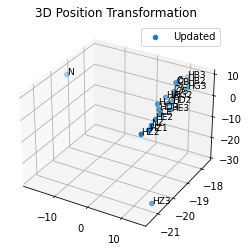

In [38]:
from matplotlib import pyplot as plt

species_strings = ['N', 'H', 'CA', 'HA', 'C', 'O', 'CB', 'HB2', 'HB3', 'CG', 'HG2', 'HG3', 'CD', 'HD2', 'HD3', 'CE', 'HE2', 'HE3', 'NZ', 'HZ1', 'HZ2', 'HZ3']

# Create a tensor with 1s for hydrogen (species == 1) and 0s elsewhere
feats = torch.where(species == 1, torch.tensor(1), torch.tensor(0)).unsqueeze(0)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(D[:, 0], D[:, 1], D[:, 2], label="Updated")

# Add labels to points
for i in range(len(D)):
    ax.text(D[i, 0], D[i, 1], D[i, 2], species_strings[i], fontsize=9)

plt.legend()
plt.title("3D Position Transformation")
plt.show()